In [6]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

In [7]:
# Fetch ADA trade raw data
today = datetime.date.today()
ADA_raw = yf.download('ADA-USD', start=today-datetime.timedelta(days=700), end=today)
# Split the raw data into parts
ADA_basic = ADA_raw[['Adj Close', 'Open']]
ADA_quant = ADA_raw

[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Prices ($)')

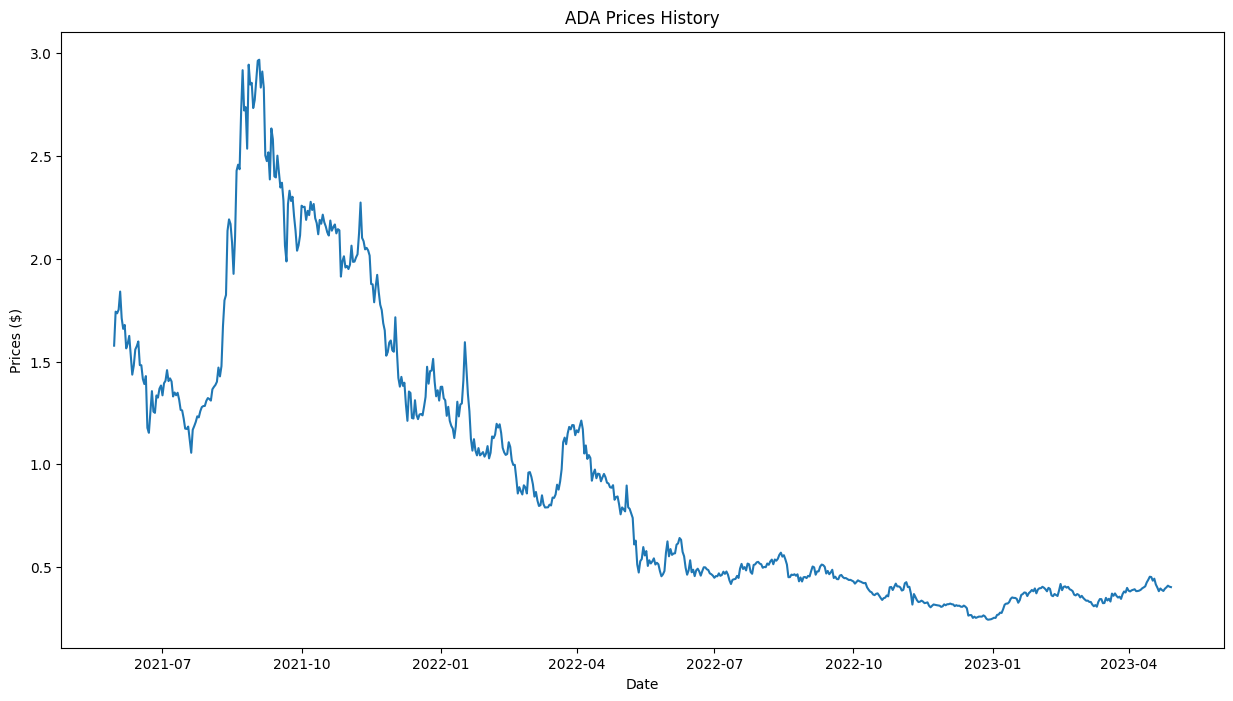

In [8]:
plt.figure(figsize=(15, 8))
plt.title('ADA Prices History')
plt.plot(ADA_quant['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [9]:
### The code below is for merge sentimental data ONLY
### The code contains the merge, split train and test data, and train the model
### The code will be commented until the sentimental data is fetched
def merge_sentimental_data(sentimental_data_file_path, ADA_data):
  # Load sentimental data in csv
  sentiment_data = pd.read_csv(sentimental_data_file_path).iloc[:, 1]
  # sentiment_data = pd.DataFrame(0, index=range(23), columns=sentiment_data.columns)
  zeros = pd.DataFrame([0]*21)
  sentiment_data = pd.concat([zeros, sentiment_data], ignore_index=True)

  # Merge with ADA quant
  merged_data = pd.concat([ADA_data, sentiment_data], axis=1)
  num_rows = len(ADA_data)

  # 创建一个与other_data索引长度相同的全0 DataFrame
  new_data_adjusted = pd.DataFrame([0] * num_rows, index=ADA_data.index)

  # 从底部开始填充sentiment_data的值
  new_data_adjusted.iloc[-len(sentiment_data):] = sentiment_data.values

  # 将new_data_adjusted添加到ADA_quant作为新的一列
  merged_data = pd.concat([ADA_data, new_data_adjusted], axis=1)
  merged_data.columns = list(ADA_data.columns) + ['sentiment']
  return merged_data

In [10]:
### The code below is for merge sentimental data ONLY
### The code contains the merge, split train and test data, and train the model
### The code will be commented until the sentimental data is fetched

sentimental_data_file_path = './ADA_vader.csv'
ADA_data = ADA_quant
merged_data = merge_sentimental_data(sentimental_data_file_path, ADA_data)

# Normalise data, if necessary
price_data = merged_data['Adj Close'].values.reshape(-1, 1)
sentiment_data = merged_data['sentiment'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_sentiment = MinMaxScaler(feature_range=(0, 1))

scaled_price_data = scaler.fit_transform(price_data)
scaled_sentiment_data = scaler_sentiment.fit_transform(sentiment_data)
# Create window size
def create_dataset(price_dataset, sentiment_dataset, look_back=1, sentiment_weight=0.01):
    x_train, y_train = [], []
    for i in range(len(price_dataset) - look_back - 1):
        x_train.append(np.hstack((price_dataset[i:(i + look_back), 0], sentiment_weight * sentiment_dataset[i:(i + look_back), 0])))
        y_train.append(price_dataset[i + look_back, 0])
    return np.array(x_train), np.array(y_train)


training_data_len = math.ceil(len(scaled_price_data) * 0.8)
training_price_data = scaled_price_data[0: training_data_len, :]
training_sentiment_data = scaled_sentiment_data[0: training_data_len, :]

# Create train set
window_size = 30
x_train, y_train = create_dataset(training_price_data, training_sentiment_data, window_size)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Create test set
test_price_data = scaled_price_data[training_data_len - window_size:, :]
test_sentiment_data = scaled_sentiment_data[training_data_len - window_size:, :]

x_test, y_test = create_dataset(test_price_data, test_sentiment_data, window_size)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = ADA_quant['Adj Close'].values[training_data_len:]

In [11]:
model = keras.Sequential()
model.add(layers.LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.Dropout(0.3))

model.add(layers.GRU(units=50, return_sequences=True))  # GRU layer
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 gru (GRU)                   (None, 60, 50)            15300     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                2

In [12]:
# GridSearch
"""
from tensorflow.keras import layers, optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def create_model(optimizer=keras.optimizers.Adam(learning_rate=0.005, amsgrad=True), dropout_rate=0.3, units=30):
    model = keras.Sequential()
    model.add(layers.LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.GRU(units=units, return_sequences=True))  # GRU layer
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.LSTM(units=units, return_sequences=True))
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.LSTM(units=units))
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(units=1))
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    return model
model = KerasRegressor(build_fn=create_model, verbose=0)
param_grid = {
    'optimizer': ['adam', 'rmsprop', 'amsgrad'],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'units': [30, 50, 70],
    'batch_size': [8, 16, 32, 64],
    'epochs': [50, 100]
}
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(x_train, y_train)
print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
"""

'\nfrom tensorflow.keras import layers, optimizers\nfrom tensorflow.keras.wrappers.scikit_learn import KerasRegressor\n\ndef create_model(optimizer=keras.optimizers.Adam(learning_rate=0.005, amsgrad=True), dropout_rate=0.3, units=30):\n    model = keras.Sequential()\n    model.add(layers.LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1], 1)))\n    model.add(layers.Dropout(dropout_rate))\n    \n    model.add(layers.GRU(units=units, return_sequences=True))  # GRU layer\n    model.add(layers.Dropout(dropout_rate))\n    \n    model.add(layers.LSTM(units=units, return_sequences=True))\n    model.add(layers.Dropout(dropout_rate))\n    \n    model.add(layers.LSTM(units=units))\n    model.add(layers.Dropout(dropout_rate))\n    \n    model.add(layers.Dense(units=1))\n    model.compile(optimizer=optimizer, loss=\'mse\', metrics=[\'accuracy\'])\n    return model\nmodel = KerasRegressor(build_fn=create_model, verbose=0)\nparam_grid = {\n    \'optimizer\': [\'adam\', \'rmsprop\

In [13]:
### Traning ###
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005, amsgrad=True), loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 32, epochs=100)
model.save(f'./ADA_model.h5')

Epoch 1/100
17/17 [==============================] - 16s 38ms/step - loss: 0.0554
Epoch 2/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0124
Epoch 3/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0100
Epoch 4/100
17/17 [==============================] - 1s 32ms/step - loss: 0.0088
Epoch 5/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0078
Epoch 6/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0068
Epoch 7/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0102
Epoch 8/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0071
Epoch 9/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0041
Epoch 10/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0051
Epoch 11/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0036
Epoch 12/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0041
Epoch 13/100
17/17 [====

In [14]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

5/5 [==============================] - 2s 8ms/step


0.0010005001977989633

<ipython-input-15-16a58ff5839d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


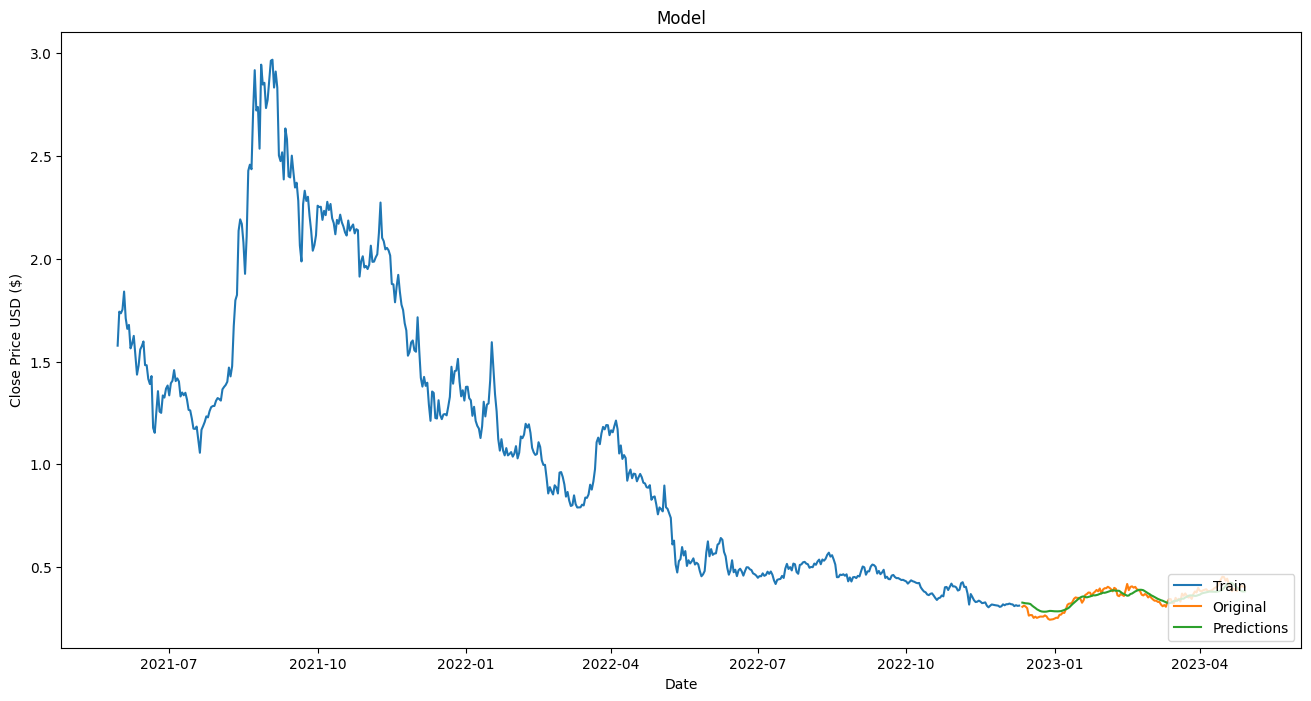

In [15]:
data = ADA_quant.filter(['Adj Close'])
train = data[:training_data_len]
validation = data[training_data_len+1:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Original', 'Predictions'], loc='lower right')
plt.savefig('./ADA_Result.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
file_path='./ADA_prediction.csv'
validation.to_csv(file_path, index=False)

In [17]:
### The code below is for dataset that merge sentimental data ONLY
### The code will be commented until the sentimental data is fetched
error = validation.iloc[-1, 0] - validation.iloc[-1, 1]
def predict(num_days_to_predict, sentimental_data_file_path):
    ### Fetch ADA-USD data BEGIN ###
    ### CHANGE THIS TO THE FUNCTION USING PYSPARK ###
    today = datetime.date.today()
    ADA_quant = yf.download('ADA-USD', start=today-datetime.timedelta(days=365), end=today)
    ### Fetch ADA-USD data END ###
    new_df=ADA_quant.filter(['Adj Close'])
    # Merge sentimental data
    merged_data = merge_sentimental_data(sentimental_data_file_path, new_df)
    # Create 30 window days slot
    last_30_days = merged_data[-30:].values
    last_30_days_price = merged_data['Adj Close'][-30:].values.reshape(-1, 1)
    last_30_days_sentiment = merged_data['sentiment'][-30:].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    last_30_days_scaled_price = scaler.fit_transform(last_30_days_price)
    sentiment_data = pd.read_csv(sentimental_data_file_path).iloc[:, 1]
    sentiment_values = sentiment_data.values.reshape(-1, 1)
    scaler_sentiment = MinMaxScaler()
    scaled_sentiment = scaler_sentiment.fit_transform(sentiment_values)
    last_30_days_scaled_sentiment = scaler_sentiment.transform(last_30_days_sentiment)
    predictions = []
    predicted_dates = []
    # Predict price
    for _ in range(num_days_to_predict):
        offset = error*(0.5-0.03*_)
        if (offset<0):
          offset = 0
        last_date = merged_data.index[-1]
        X_test = []
        X_test.append(np.hstack((last_30_days_scaled_price.flatten(), last_30_days_scaled_sentiment.flatten())))
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        pred_price = model.predict(X_test)
        pred_price_unscaled = scaler.inverse_transform(pred_price)
        predictions.append(pred_price_unscaled[0][0]+offset)
        last_30_days_scaled_price = np.concatenate((last_30_days_scaled_price[1:], pred_price), axis=0)
        predicted_date = last_date + datetime.timedelta(days=_+1)
        predicted_dates.append(predicted_date)
    # print(f"Price of ADA-USD for the next {num_days_to_predict} trading days: {predictions}")
    output_text = f"Price of ADA-USD for the next {num_days_to_predict} trading days: {predictions}"
    print(output_text)
    # file_name = f"./public/ADA/Prediction_{num_days_to_predict}days.txt"
    # with open(file_name, 'w') as file:
      # file.write(output_text)
    fig, ax = plt.subplots()
    ax.plot(predicted_dates, predictions, marker='o', label='Predicted Prices')
    ax.set(xlabel='Date', ylabel='ADA-USD Price', title=f'Predicted ADA-USD Prices for the Next {num_days_to_predict} Trading Days')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.set_xlim(predicted_dates[0] - datetime.timedelta(days=2), predicted_dates[0] + datetime.timedelta(days=num_days_to_predict+3))
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    # plt.savefig(f'/src/Components/ADA/Prediction_{num_days_to_predict}days', dpi=300, bbox_inches='tight')
    plt.show()

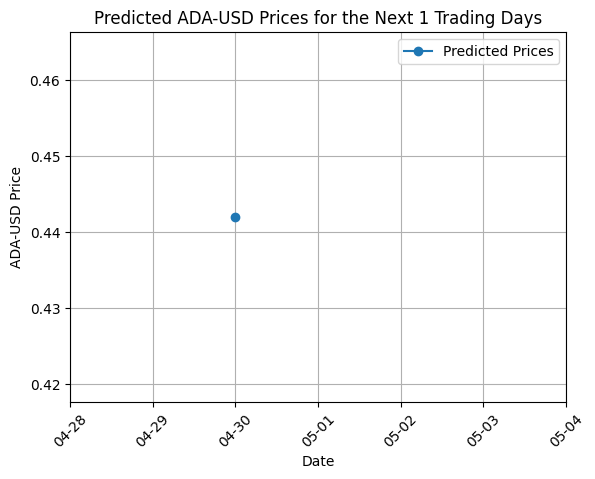

In [18]:
sentimental_data_file_path = './ADA_vader.csv'
predict(1, sentimental_data_file_path)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 26ms/step
Price of ADA-USD for the next 3 trading days: [0.44202128052711487, 0.4377226716279983, 0.43436820030212403]


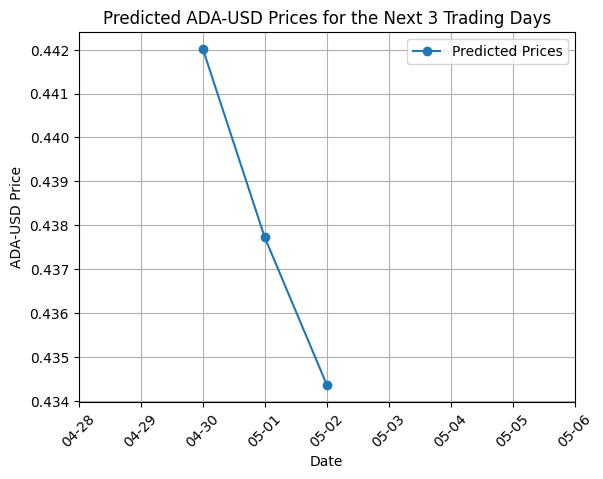

In [19]:
predict(3, sentimental_data_file_path)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 37ms/step
Price of ADA-USD for the next 5 trading days: [0.44202128052711487, 0.4377226716279983, 0.43436820030212403, 0.43237039029598234, 0.4319372022151947]


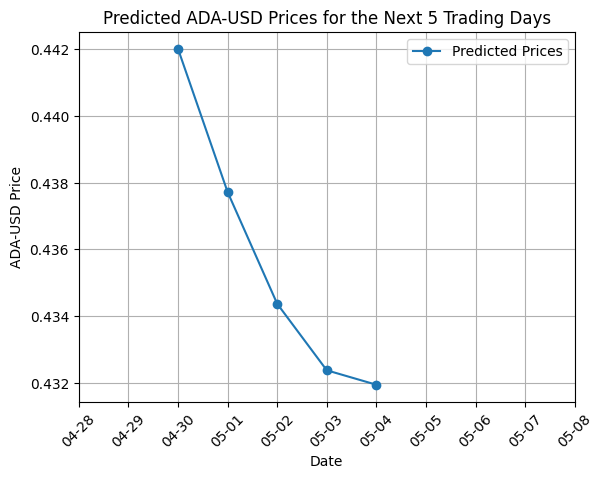

In [20]:
predict(5, sentimental_data_file_path)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 35ms/step
Price of ADA-USD for the next 30 trading days: [0.44202128052711487, 0.4377226716279983, 0.43436820030212403, 0.43237039029598234, 0.4319372022151947, 0.4328795999288559, 0.4348465716838837, 0.43754325330257415, 0.4406787741184235, 0.4442535811662674, 0.44812232851982114, 0.4515028840303421, 0.45328093886375426, 0.45279702723026277, 0.4487627649307251, 0.44322956502437594, 0.4431372857093811, 0.44628047943115234, 0.44862279295921326, 0.4500088393688202, 0.4504548907279968, 0.4506107568740845, 0.45063650608062744, 0.4506033658981323, 0.4505408704280853, 0.45048418641090393, 0.4504248797893524, 0.45036759972572327, 0.45030438899993896, 0.45028313994407654]


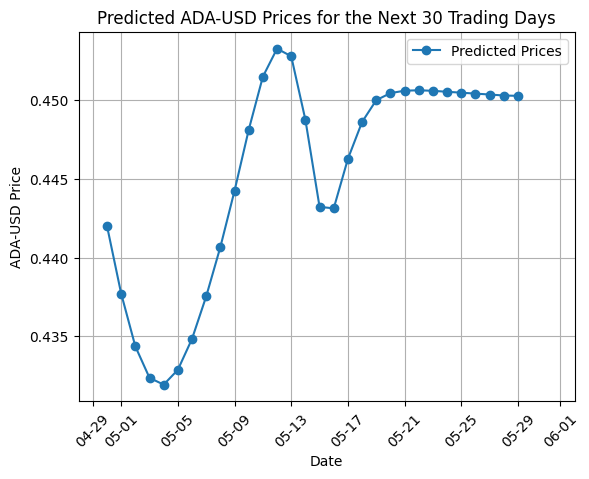

In [21]:
predict(30, sentimental_data_file_path)